In [1]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
%matplotlib inline
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name, size=12)
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
# model = Seq2seq(vocab_size, wordvec_size, hideen_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

peeky_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad, eval_interval=150)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    peeky_acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 151 / 351 | 시간 6[s] | 손실 1.99
| 에폭 1 |  반복 301 / 351 | 시간 13[s] | 손실 1.76
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1013
---
Q 582+84 
T 666 
X 102 
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1023
---
Q 600+257
T 857 
X 1023
---
Q 761+292
T 1053
X 1023
---
Q 830+597
T 1427
X 1111
---
Q 26+838 
T 864 
X 102 
---
Q 143+93 
T 236 
X 102 
---
검증 정확도 0.280%
| 에폭 2 |  반복 1 / 351 | 시간 0[s] | 손실 1.71
| 에폭 2 |  반복 151 / 351 | 시간 6[s] | 손실 1.70
| 에폭 2 |  반복 301 / 351 | 시간 13[s] | 손실 1.64
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1200
---
Q 582+84 
T 666 
X 690 
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 690 
---
Q 600+257
T 857 
X 999 
---
Q 761+292
T 1053
X 1029
---
Q 830+597
T 1427
X 1240
---
Q 26+838 
T 864 
X 792 
---
Q 143+93 
T 236 
X 290 
---
검증 정확도 0.400%
| 에폭 3 |  반복 1 / 351 | 시간 0[s] | 손실 1.58
| 에폭 3 |  반복 151 / 351 | 시간 5[s] | 손실 1.54
| 에폭 3 |  반복 301 / 351 | 시간 9[s] | 손실 1.43
Q 77+85  
T 162 
X 154 
---
Q

검증 정확도 97.200%
| 에폭 21 |  반복 1 / 351 | 시간 0[s] | 손실 0.02
| 에폭 21 |  반복 151 / 351 | 시간 4[s] | 손실 0.02
| 에폭 21 |  반복 301 / 351 | 시간 9[s] | 손실 0.02
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
O 1427
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 97.440%
| 에폭 22 |  반복 1 / 351 | 시간 0[s] | 손실 0.01
| 에폭 22 |  반복 151 / 351 | 시간 4[s] | 손실 0.05
| 에폭 22 |  반복 301 / 351 | 시간 9[s] | 손실 0.02
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
O 1427
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 98.480%
| 에폭 23 |  반복 1 / 351 | 시간 0[s] | 손실 0.01
| 에폭 23 |  반복 151 / 351 | 시간 5[s] | 손실 0.01
| 에폭 23 |  반복 301 / 351 | 시간 10[s] | 손실 0.01
Q 77

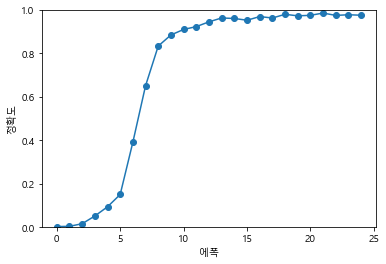

In [4]:
# 그래프 그리기
x_peeky = np.arange(len(peeky_acc_list))
plt.plot(peeky_acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()